In [8]:
#@title Simple division as deconvolution
import numpy as np
from scipy.signal import convolve2d
from numpy.fft import fft2, ifft2, fftshift
from google.colab.patches import cv2_imshow
import cv2

def generate_gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    """
    Generates a 2D Gaussian kernel.

    Parameters:
        size (int): The size of the kernel (must be odd).
        sigma (float): The standard deviation of the Gaussian.

    Returns:
        np.ndarray: A 2D Gaussian kernel.
    """
    if size % 2 == 0:
        raise ValueError("Kernel size must be odd.")

    # Create a grid of (x, y) coordinates centered at zero
    radius = size // 2
    x = np.arange(-radius, radius + 1)
    y = np.arange(-radius, radius + 1)
    x, y = np.meshgrid(x, y)

    # Compute the Gaussian function
    gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normalize the kernel so that the sum of all elements is 1
    kernel = gaussian / gaussian.sum()

    return kernel

def circular_kernel(radius):
    """Generate a circular disk-shaped kernel with given radius."""
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float32)
    kernel[mask] = 1
    return kernel / kernel.sum()  # Normalize the kernel

def psf2otf(psf, shape):
    """
    Converts a point spread function to an optical transfer function.
    Args:
        psf (np.ndarray): Point spread function.
        shape (tuple): Shape of the output array.
    Returns:
        np.ndarray: Optical transfer function.
    """
    # Calculate the amount of padding needed on each side
    pad_h = shape[0] - psf.shape[0]
    pad_w = shape[1] - psf.shape[1]

    # Pad the PSF, ensuring the origin is in the center
    padded_psf = np.pad(psf, ((pad_h // 2, (pad_h + 1) // 2), (pad_w // 2, (pad_w + 1) // 2)), mode='constant')

    # Now, fftshift to move the origin to the top-left corner for FFT
    shifted_psf = np.fft.fftshift(padded_psf)

    # Compute the FFT
    otf = fft2(shifted_psf)

    return otf



# import image
img = cv2.imread('dsc_0085.jpg', cv2.IMREAD_GRAYSCALE)[1200:2000,1200:2000]
# generate blur kernel
blur_kernel = motion_blur_kernel #circular_kernel(12)
# fft of input image
fft_img = fft2(img)
# fft of kernel with padding
fft_kernel = psf2otf(blur_kernel, img.shape)
# convolution
fft_conv = fft_img * fft_kernel
# visualize blurred image with inverse fft
blurred_img = ifft2(fft_conv)
# Basic deconvultion with frequncy domain division
reconstructed_img = (ifft2(fft2(blurred_img) /
                            psf2otf(blur_kernel, img.shape)))

cv2_imshow(img)
cv2_imshow(fft_img)
cv2_imshow(fft_kernel*255)
cv2_imshow(blurred_img)
cv2_imshow(reconstructed_img)



Output hidden; open in https://colab.research.google.com to view.

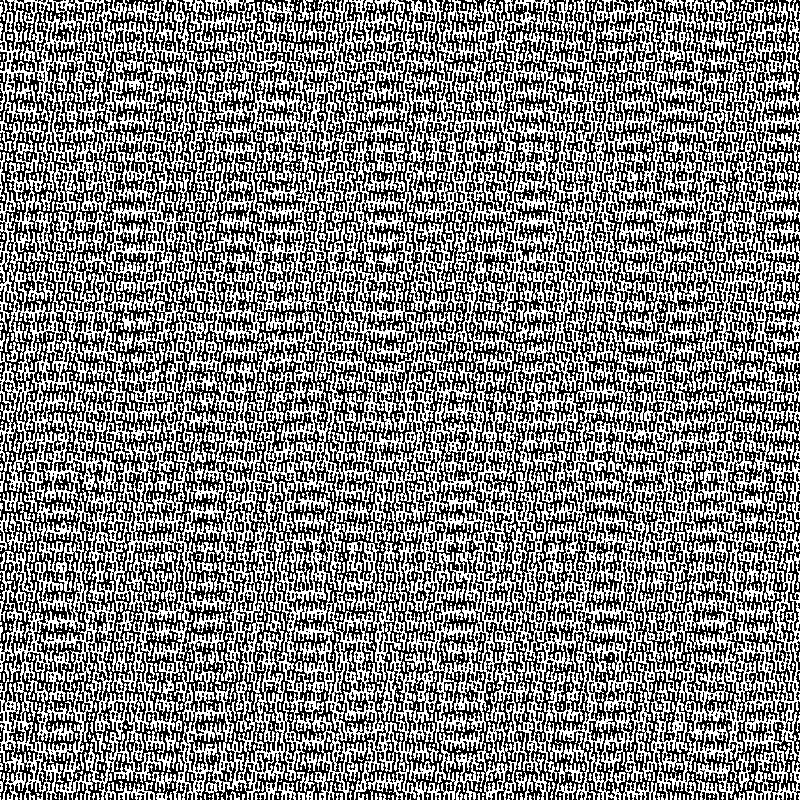

In [5]:
#@title preturbed kernel
bad_blur_kernal = circular_kernel(11)
bad_img = (ifft2(fft2(blurred_img) /
                            psf2otf(bad_blur_kernal, img.shape)))
cv2_imshow(bad_img)

In [6]:
6e3

6000.0

Blur kernel created successfully:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.03207547 0.00264151 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00314465
  0.02616352 0.00163522 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00352201
  0.02075472 0.00314465 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  

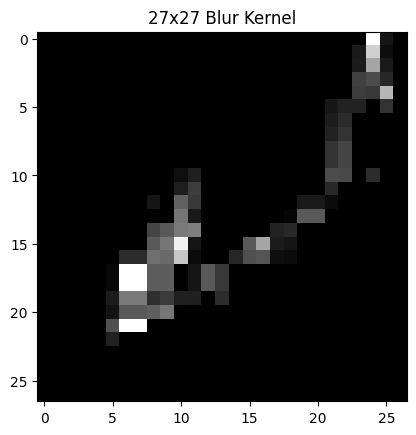

In [7]:
import cv2
import numpy as np

def create_blur_kernel_from_image(image_path, kernel_size=27):
  """
  Converts an image into a blur kernel of a specified size.

  Args:
    image_path: Path to the input image.
    kernel_size: The desired size of the square kernel (e.g., 27 for a 27x27 kernel).

  Returns:
    A NumPy array representing the blur kernel, or None if an error occurs.
  """
  try:
    # 1. Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
      print(f"Error: Could not load image at {image_path}")
      return None

    # 2. Resize the image to the desired kernel size
    resized_img = cv2.resize(img, (kernel_size, kernel_size))

    # 3. Normalize the pixel values to create a kernel
    kernel = resized_img.astype(np.float32) / 255.0

    # 4. Normalize the kernel so that the sum of its elements is 1 (important for a blur kernel)
    kernel /= np.sum(kernel)

    return kernel

  except Exception as e:
    print(f"An error occurred: {e}")
    return None

# Example usage:
image_path = "motion_blur_kernel.png"  # Replace with your image path
kernel_size = 27

motion_blur_kernel = create_blur_kernel_from_image(image_path, kernel_size)

if blur_kernel is not None:
  print("Blur kernel created successfully:")
  print(motion_blur_kernel)

  # Optional: Visualize the kernel
  import matplotlib.pyplot as plt
  plt.imshow(motion_blur_kernel, cmap='gray')
  plt.title("27x27 Blur Kernel")
  plt.show()

  # Optional: Save the kernel to a file (e.g., as a text file or using NumPy's save function)
  # np.savetxt("blur_kernel.txt", blur_kernel)
  # np.save("blur_kernel.npy", blur_kernel)

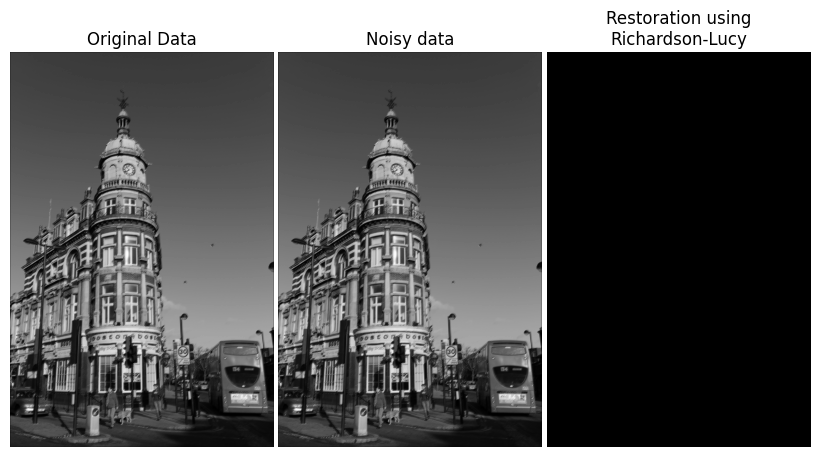

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration

rng = np.random.default_rng()

astro = cv2.imread('dsc_0085.jpg', cv2.IMREAD_GRAYSCALE) #color.rgb2gray(data.astronaut())

psf = motion_blur_kernel #np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (rng.poisson(lam=25, size=astro.shape) - 10) / 255.0

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, num_iter=30)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
    a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
plt.show()